## Module Import

In [1]:
import os
import numpy as np

import torch
from torch.utils.data import DataLoader

import torchvision.models as models
from torchvision import transforms
from torchvision.datasets import ImageFolder

from tqdm import tqdm_notebook

save_outputs = True # whether to save intermediate outputs for later reuse.
if save_outputs:
    output_dir = 'outputs/vgg16_bn/'
    os.makedirs(output_dir, exist_ok=True)

## Initialize vgg16_bn

In [2]:
net = models.vgg16_bn(pretrained=True)
net.eval()
net.cuda();

## and set hooks to extract hidden activations across layers

In [3]:
hidden_outputs = {}
def named_hook(name):
    def hook(module, input, output):
        hidden_outputs[name] = output
    return hook

# activations = dict(features_2=[], features_5=[], features_9=[],
#                    features_12=[], features_16=[], features_19=[],
#                    features_22=[], features_26=[], features_29=[],
#                    features_32=[], features_36=[], features_39=[],
#                    features_42=[], classifier_1=[], classifier_4=[])
activations = dict(features_12=[], features_16=[], features_19=[],
                   features_22=[], features_26=[], features_29=[],
                   features_32=[], features_36=[], features_39=[],
                   features_42=[], classifier_1=[], classifier_4=[])

for name in activations.keys():
    meta_arch_name, layer_idx = name.split('_')
    layer_idx = int(layer_idx)
    if meta_arch_name == 'features':
        net.features[layer_idx].register_forward_hook(named_hook(meta_arch_name+'_'+str(layer_idx)))
    elif meta_arch_name == 'classifier':
        net.classifier[layer_idx].register_forward_hook(named_hook(meta_arch_name+'_'+str(layer_idx)))
            
    print('{}_{} activations are registered'.format(meta_arch_name, layer_idx))

features_12 activations are registered
features_16 activations are registered
features_19 activations are registered
features_22 activations are registered
features_26 activations are registered
features_29 activations are registered
features_32 activations are registered
features_36 activations are registered
features_39 activations are registered
features_42 activations are registered
classifier_1 activations are registered
classifier_4 activations are registered


## Initialize dataset & data loader

In [4]:
img_root = './data/ILSVRC2012_img_val/'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

num_class = 1000
imgs_per_class = 50
batch_size = 25
iters_per_class = imgs_per_class//batch_size
assert imgs_per_class/batch_size == float(iters_per_class)

num_workers = 6
dset = ImageFolder(img_root, transform=transform)
dloader = DataLoader(dset, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=num_workers)
print('# of images :', len(dset))

# of images : 50000


## Extract hidden activations

In [5]:
print('start extracting class-conditional hidden activations.')
loader = iter(dloader)
for i in tqdm_notebook(range(num_class)):
    
    class_conditional_activations = dict()
    for name in activations:
        class_conditional_activations[name] = 0.
    
    for k in range(iters_per_class):
        img, label = loader.next()
        img = img.cuda()
        net(img)

        for name in activations:
            meta_arch_name, layer_idx = name.split('_')
            layer_idx = int(layer_idx)
            output_name = meta_arch_name+'_'+str(layer_idx)
            class_conditional_activations[name] += hidden_outputs[output_name].view(batch_size, -1).sum(0).div(imgs_per_class).data.cpu()
            
    for name in activations:
        activations[name].append(class_conditional_activations[name])
        
print('merge activations. this takes time if save_outputs==True')
for name in activations:
    activations[name] = torch.stack(activations[name], dim=0)
    
    if save_outputs:
        activations_path = os.path.join(output_dir, name+'_activations.pth')
        with open(activations_path, 'wb+') as f:
            torch.save(activations[name], activations_path)
        print('{} is saved'.format(activations_path))

start extracting class-conditional hidden activations.



merge activations. this takes time if save_outputs==True
outputs/vgg16_bn/features_12_activations.pth is saved
outputs/vgg16_bn/features_16_activations.pth is saved
outputs/vgg16_bn/features_19_activations.pth is saved
outputs/vgg16_bn/features_22_activations.pth is saved
outputs/vgg16_bn/features_26_activations.pth is saved
outputs/vgg16_bn/features_29_activations.pth is saved
outputs/vgg16_bn/features_32_activations.pth is saved
outputs/vgg16_bn/features_36_activations.pth is saved
outputs/vgg16_bn/features_39_activations.pth is saved
outputs/vgg16_bn/features_42_activations.pth is saved
outputs/vgg16_bn/classifier_1_activations.pth is saved
outputs/vgg16_bn/classifier_4_activations.pth is saved


## Calculate Class Selectivity Index

In [6]:
print('start calculating class selectivity index')
result = {}
for name in activations:
    layer_act = activations[name]

    num_class, num_neuron = layer_act.size()
    dead_neuron_class = torch.tensor(num_class)
    dead_neuron_confidence = torch.tensor(0.)

    selected_class = []
    selectivity_index = []
    for neuron_idx in tqdm_notebook(range(num_neuron)):
        neuron_act = layer_act[:, neuron_idx]

        # In the case of mean activations of a neuron are all zero across whole classes
        # Simply consider that neuron as dead neuron.
        if neuron_act.nonzero().size(0) == 0: 
            class_selected = dead_neuron_class
            class_confidence = dead_neuron_confidence
        else:
            class_selected = neuron_act.argmax()
            mu_max = neuron_act[class_selected]
            mu_mmax = (neuron_act.sum()-mu_max).div(num_class-1)
            class_confidence = (mu_max-mu_mmax).div(mu_max+mu_mmax)

        selected_class.append(class_selected)   
        selectivity_index.append(class_confidence)

    selected_class = torch.stack(selected_class, 0)
    selectivity_index = torch.stack(selectivity_index, 0)
    
    result[name] = dict()
    result[name]['selected_class'] = selected_class
    result[name]['selectivity_index'] = selectivity_index
    
    if save_outputs:
        result_path = os.path.join(output_dir, name+'_selectivity_results.pth')
        with open(result_path, 'wb+') as f:
            torch.save(result[name], result_path)
        print('{} is saved'.format(result_path))

start calculating class selectivity index



outputs/vgg16_bn/features_12_selectivity_results.pth is saved



outputs/vgg16_bn/features_16_selectivity_results.pth is saved



outputs/vgg16_bn/features_19_selectivity_results.pth is saved



outputs/vgg16_bn/features_22_selectivity_results.pth is saved



outputs/vgg16_bn/features_26_selectivity_results.pth is saved



outputs/vgg16_bn/features_29_selectivity_results.pth is saved



outputs/vgg16_bn/features_32_selectivity_results.pth is saved



outputs/vgg16_bn/features_36_selectivity_results.pth is saved



outputs/vgg16_bn/features_39_selectivity_results.pth is saved



outputs/vgg16_bn/features_42_selectivity_results.pth is saved



outputs/vgg16_bn/classifier_1_selectivity_results.pth is saved



outputs/vgg16_bn/classifier_4_selectivity_results.pth is saved


## Plot class selectivity distributions as a function of depth

/home/wonkonge/anaconda3/envs/kongda_py36_torch40/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  import sys


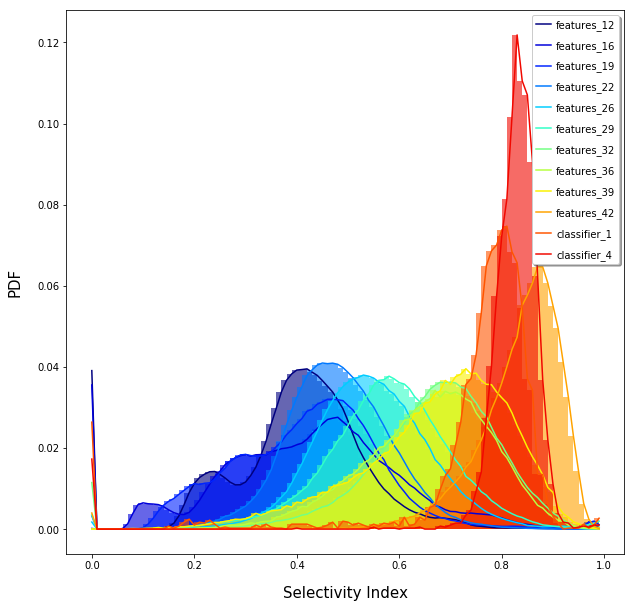

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

num_plots = len(result)
colormap = plt.cm.jet
plt.figure(figsize=(10,10))
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)]);

labels = []
for name in result:
    selectivity_index = result[name]['selectivity_index']
    selectivity_index_hist = np.histogram(selectivity_index*100, bins=100, normed=True)
    x = np.arange(len(selectivity_index_hist[0]))/len(selectivity_index_hist[0])
    y = selectivity_index_hist[0]
    plt.fill_between(x, y, step="pre", alpha=0.6)
    plt.plot(x, y)
    labels.append(name)

plt.legend(labels, ncol=1, loc='upper right', 
           columnspacing=2.0, labelspacing=1,
           handletextpad=0.5, handlelength=1.5,
           fancybox=True, shadow=True)
plt.ylabel('PDF', fontsize=15, labelpad=15)
plt.xlabel('Selectivity Index', fontsize=15, labelpad=15)
plt.show()